In [11]:
import yfinance as yf
from datetime import datetime, timedelta
import statsmodels.api as sm
import pandas as pd

tickerSymbol = 'SPY'

data = pd.read_csv("data_stocks/AAPL.csv")

data.index = pd.to_datetime(data["ts_event"])
data.drop(columns = "ts_event", inplace=True)

#### one year
data = data[(data.index >=  "2021-01-01") & (data.index <  "2024-01-01")]
data["perf"] = (data["close"] - data["close"].shift(1))/data["close"].shift(1)
display(data)



,open,high,low,close,volume,perf
ts_event,,,,,,
2021-01-04,133800000000,134430000000,126760000000,129250000000,35408893,NaN
2021-01-05,129940000000,131740000000,128320000000,130740000000,19921518,0.011528
2021-01-06,128190000000,131040000000,126310000000,127370000000,34897192,-0.025776
2021-01-07,127990000000,131625000000,127410000000,130960000000,23925753,0.028186
2021-01-08,131660000000,132840000000,130230000000,131910000000,22448608,0.007254
...,...,...,...,...,...,...
2023-12-22,194500000000,195410000000,192970000000,193590000000,11845160,-0.005343
2023-12-26,193750000000,194130000000,192830000000,192940000000,9127535,-0.003358
2023-12-27,193000000000,193495000000,191095000000,193160000000,13822344,0.001140


In [11]:
import pandas as pd
pd.read_csv("LSTM_results.csv").sort_values("mse")

,Unnamed: 0,layers,hidden,dropout,lr,mse,batch_size
55,NaN,1.0,64.0,0.1,0.0100,5.017536e+18,16.0
0,0.0,0.0,0.0,0.0,0.0000,5.214645e+18,NaN
1,1.0,0.0,0.0,0.0,0.0000,5.214645e+18,NaN
2,2.0,0.0,0.0,0.0,0.0000,5.214645e+18,NaN
3,3.0,0.0,0.0,0.0,0.0000,5.214645e+18,NaN
...,...,...,...,...,...,...,...
11,NaN,1.0,8.0,0.3,0.0001,3.486427e+19,16.0
25,NaN,2.0,8.0,0.1,0.0001,3.498429e+19,16.0
31,NaN,2.0,16.0,0.3,0.0001,3.777895e+19,16.0
29,NaN,2.0,16.0,0.1,0.0001,4.004119e+19,16.0


In [12]:
import pmdarima as pm
trainwindow = 600
test = 150
ts = data['perf'].dropna().to_numpy()
# Fit the ARIMA model
model = pm.auto_arima(ts[:600], start_p=2, start_q=2, max_p=3, max_q=3, m=1, start_P=0, seasonal=False, d=None, D=None, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# Display the model summary
print(model.summary())

# Get the optimal parameters
order = model.order
seasonal_order = model.seasonal_order

# Display the optimal parameters
print("Optimal ARIMA Order:", order)
print("Optimal Seasonal Order:", seasonal_order)

# Get the fitting coefficients
coefficients = model.params()

# Display the fitting coefficients
print("Fitting Coefficients:")
for i, coef in enumerate(coefficients):
    print(f"ARIMA({order[0]},{order[1]},{order[2]}) - Coefficient {i+1}: {coef}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3060.466, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-3065.989, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3065.078, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3065.175, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3063.403, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-3064.714, Time=0.06 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.327 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  600
Model:                        SARIMAX   Log Likelihood                1533.995
Date:                Mon, 04 Mar 2024   AIC                          -3065.989
Time:                        15:10:55   BIC                          -3061.592
Sample:                             0   HQIC                         -3064.278
    

100%|██████████| 453/453 [07:42<00:00,  1.02s/it]


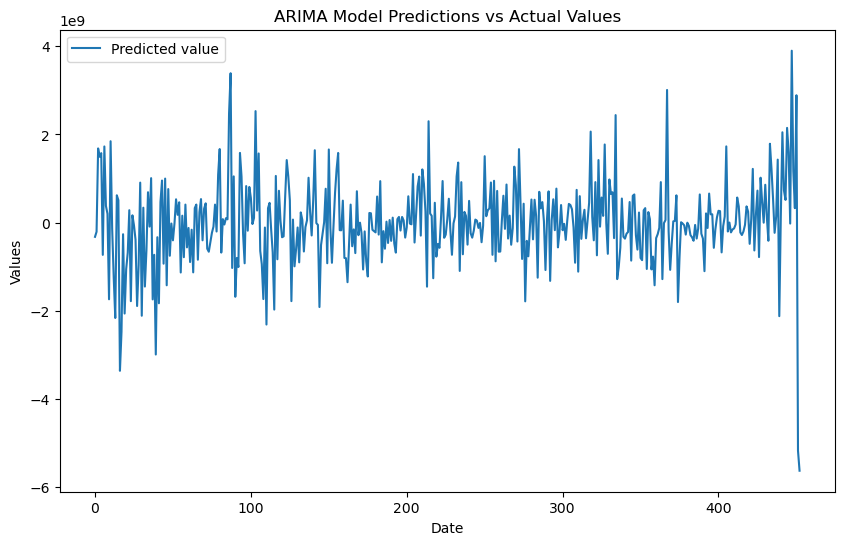

0.967928263742403
9.314490197425766e+17


In [2]:
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np
from sklearn.metrics import r2_score  as r2
from sklearn.metrics import mean_squared_error as mse
import tqdm

trainWindow = 300
# ARIMA
ts = data['close'].to_numpy()


ytrue = ts[trainWindow:]
ypred = []
index = [i for i in range(len(ytrue))]

p = []
d = []
q = []

for i in tqdm.tqdm(range(len(ytrue))):
    trainSet = ts[i:i+trainWindow]
    model = pm.auto_arima(trainSet)
    ypred.append(model.predict(n_periods = 1)[0])
    p.append(model.order[0])
    d.append(model.order[1])
    q.append(model.order[2])

orders = pd.DataFrame()
orders["p"] = p
orders["d"] = d
orders["q"] = q







    


# Plotting the results
plt.figure(figsize=(10, 6))
#plt.plot(index, ytrue, label='Reel value')
#plt.plot(index, ypred, label='Predicted value')
plt.plot(index, np.subtract(ytrue,ypred), label='Predicted value')
plt.title('ARIMA Model Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

print(r2(ytrue,ypred))
print(mse(ytrue,ypred))


In [3]:
# Plotting the results
print(mse(ytrue[:-1],ytrue[1:]))

6.149498574286342e+17


In [4]:
orders

,p,d,q
0,2,1,2
1,2,1,2
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
448,0,1,0
449,0,1,0
450,2,2,1
451,2,2,1


In [5]:
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np
from sklearn.metrics import r2_score  as r2
from sklearn.metrics import mean_squared_error as mse
import tqdm


# ARIMA
ts = data['close'].to_numpy()
errors = []
window = []

for trainWindow in tqdm.tqdm(range(25,200,5)):

    ytrue = ts[trainWindow:]
    ypred = []
    index = [i for i in range(len(ytrue))]

    for i in range(len(ytrue)):
        trainSet = ts[i:i+trainWindow]
        model = pm.auto_arima(trainSet)
        ypred.append(model.predict(n_periods = 1)[0])

    errors.append(mse(ytrue,ypred))
    window.append(trainWindow)

res = pd.DataFrame()
res["TrainingWindow"] = window
res["MSE"] = errors

res.to_csv("MSE_1d_pred_ARIMA.csv")
    


# Plotting the results
plt.figure(figsize=(10, 6))
#plt.plot(index, ytrue, label='Reel value')
#plt.plot(index, ypred, label='Predicted value')
plt.plot(index, np.subtract(ytrue,ypred), label='Predicted value')
plt.title('ARIMA Model Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

print(r2(ytrue,ypred))
print(mse(ytrue,ypred))

 14%|█▍        | 5/35 [14:59<1:30:54, 181.80s/it]

In [ ]:
model.order[0]

2

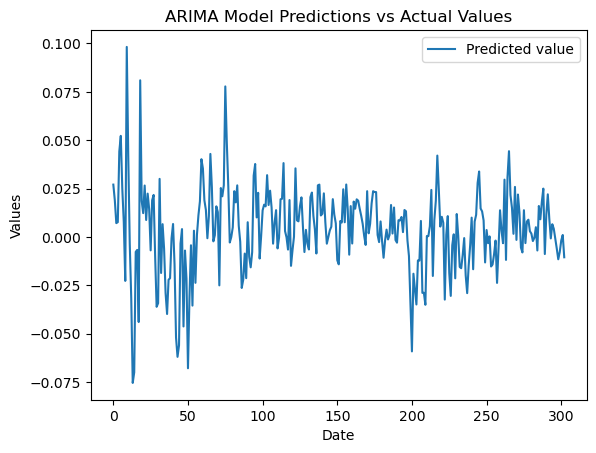

In [ ]:
plt.plot(index, np.divide(ytrue,ypred) - 1, label='Predicted value')
plt.title('ARIMA Model Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from datetime import datetime, timedelta
import statsmodels.api as sm
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_squared_error


tickerSymbol = 'SPY'

data = pd.read_csv("data_stocks/AAPL.csv")

data.index = pd.to_datetime(data["ts_event"])

data.drop(columns = "ts_event", inplace=True)

ts = data['close'].to_numpy()


# Create the ARIMA model
numpred = 140
results = []
for d in range(1,2):
    for p in range(0,5):
        for q in range(0,5):

            predictions = []
            for i in tqdm(range(numpred,0,-1)):
                model = ARIMA(ts[:-i], order=(p, d, q))

                model_fit = model.fit()

                pred = model_fit.forecast(step=1)
                predictions.append(pred[0])

            #mse
            print("For ({}, {}, {}), We have the MSE: {}".format(p,d,q,mean_squared_error(ts[-numpred:], predictions)))
            results.append([p,d,q,mean_squared_error(ts[-numpred:], predictions)])



  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 81%|████████  | 113/140 [00:09<00:02, 12.32it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  2%|▏         | 3/140 [00:00<00:06, 22.83it/s]

For (0, 1, 0), We have the MSE: 5.306920714285714e+18


  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  1%|▏         | 2/140 [00:00<00:10, 12.61it/s]

For (0, 1, 1), We have the MSE: 5.346123666208145e+18


  0%|          | 0/140 [00:00<?, ?it/s]

For (0, 1, 2), We have the MSE: 5.326093902003523e+18


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  1%|          | 1/140 [00:00<00:21,  6.37it/s]

For (0, 1, 3), We have the MSE: 5.323677787639988e+18


  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  2%|▏         | 3/140 [00:00<00:06, 22.04it/s]

For (0, 1, 4), We have the MSE: 5.325117097256194e+18


  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  1%|▏         | 2/140 [00:00<00:08, 16.87it/s]

For (1, 1, 0), We have the MSE: 5.347052352762269e+18


  0%|          | 0/140 [00:00<?, ?it/s]

For (1, 1, 1), We have the MSE: 5.346399294337607e+18


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  1%|          | 1/140 [00:00<00:18,  7.56it/s]

For (1, 1, 2), We have the MSE: 5.319536511258754e+18


  0%|          | 0/140 [00:00<?, ?it/s]

For (1, 1, 3), We have the MSE: 5.323530154887429e+18


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  1%|          | 1/140 [00:00<00:19,  7.11it/s]

For (1, 1, 4), We have the MSE: 5.3250243197255e+18


  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


For (2, 1, 0), We have the MSE: 5.325793539718956e+18


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  0%|          | 0/140 [00:00<?, ?it/s]

For (2, 1, 1), We have the MSE: 5.319236287464753e+18


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  0%|          | 0/140 [00:00<?, ?it/s]

For (2, 1, 2), We have the MSE: 5.300493130508383e+18


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  1%|          | 1/140 [00:00<00:25,  5.52it/s]

For (2, 1, 3), We have the MSE: 5.307175305984658e+18


  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  1%|▏         | 2/140 [00:00<00:09, 14.08it/s]

For (2, 1, 4), We have the MSE: 5.322385146074177e+18


  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  1%|          | 1/140 [00:00<00:26,  5.20it/s]

For (3, 1, 0), We have the MSE: 5.322270251482415e+18


  0%|          | 0/140 [00:00<?, ?it/s]

For (3, 1, 1), We have the MSE: 5.323964682325957e+18


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  0%|          | 0/140 [00:00<?, ?it/s]

For (3, 1, 2), We have the MSE: 5.311700693238716e+18


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  0%|          | 0/140 [00:00<?, ?it/s]

For (3, 1, 3), We have the MSE: 5.293493273478403e+18


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  1%|▏         | 2/140 [00:00<00:12, 10.96it/s]

For (3, 1, 4), We have the MSE: 5.312798057724023e+18


  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  1%|          | 1/140 [00:00<00:19,  7.18it/s]

For (4, 1, 0), We have the MSE: 5.324374716187382e+18


  0%|          | 0/140 [00:00<?, ?it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  1%|          | 1/140 [00:00<00:18,  7.35it/s]

For (4, 1, 1), We have the MSE: 5.324515772297834e+18


  0%|          | 0/140 [00:00<?, ?it/s]

For (4, 1, 2), We have the MSE: 5.324576854570353e+18


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
 57%|█████▋    | 80/140 [01:12<00:58,  1.03it/s]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 0/140 [00:00<?, ?it/s]

For (4, 1, 3), We have the MSE: 5.313520411894895e+18


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['step']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
  1%|          | 1/140 [00:01<03:13,  1.39s/it]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  1%|▏         | 2/140 [00:02<03:04,  1.34s/it]/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to c

For (4, 1, 4), We have the MSE: 5.313986039089008e+18


In [111]:
resdf = pd.DataFrame(results, columns = ["p","d","q","mse"]).sort_values("mse")

In [114]:
resdf.sort_values("mse")

,p,d,q,mse
18,3,1,3,5.293493e+18
12,2,1,2,5.300493e+18
0,0,1,0,5.306921e+18
13,2,1,3,5.307175e+18
17,3,1,2,5.311701e+18
19,3,1,4,5.312798e+18
23,4,1,3,5.313520e+18
24,4,1,4,5.313986e+18
11,2,1,1,5.319236e+18
7,1,1,2,5.319537e+18


/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


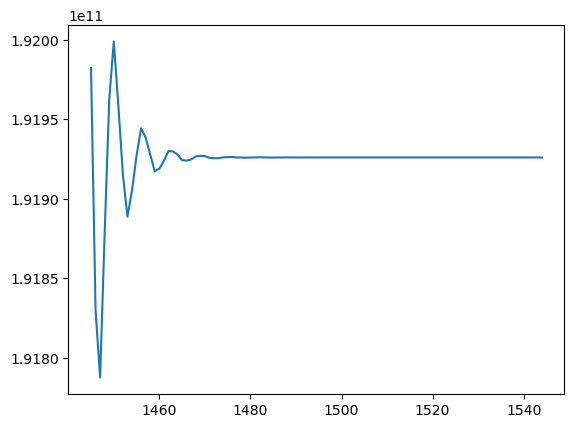

In [82]:
import matplotlib.pyplot as plt

plt.plot(model_fit.forecast(steps=100))
plt.show()